Расчёт доходности порфеля на основе ежемесячных отчетов брокера "Сбербанк Инвестор"

In [1]:
import os
import numpy as np
import pandas as pd
import pandas_datareader
import pandas_datareader.moex as moex
from lxml import etree, html
from lxml.etree import tostring
import re
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 100 # 200
pd.set_option('display.max_rows', None)

In [2]:
sber_date_format = '%d.%m.%Y'

h1 = {
    'Торговая площадка': 'section',
    'Оценка портфеля ЦБ, руб.': 'cost',
    'Денежные средства, руб.': 'cash',
    'Оценка, руб.': 'all_cost',
    'Дата': 'date',
    'Описание операции': 'operation',
    'Валюта': 'currency',
    'Сумма зачисления': 'inflow',
    'Сумма списания': 'outflow',
    'Сумма': 'cash',
    'Наименование': 'shortname',
    'ISIN ценной бумаги': 'ISIN',
    'Валюта рыночной цены': 'currency',
    'Количество, шт': 'count',
    'Номинал*': 'value',
    'Рыночная цена **': 'market_price',
    'Рыночная стоимость, без НКД***': 'market_price2',
    'НКД****':'interest'}

In [3]:
def asset_valuation(t, cc, sd, ed):
    t.remove(t[-1])
    df = pd.read_html(tostring(t), header=0)[0]
    #df = df[:-1]
    df.rename(columns=h1, inplace=True)
    for h in ['cost', 'cash', 'all_cost']:
        if (df[h].dtype != np.float64):
            df[h] = pd.to_numeric(df[h].str.replace(' ', ''))
    df['contract'] = cc
    df['date'] = ed
    return df


def ind_inv_account(t, cc, sd, ed):
    return None


def securities_portfolio(t, cc, sd, ed):
    t.remove(t[-1])
    df = pd.read_html(tostring(t), header=0, skiprows=[0,2])[0]
    df.rename(columns=h1, inplace=True)
    df_1 = df.iloc[:,[0,1,2,3,4,5,6,7]].copy()
    df_2 = df.iloc[:,[0,1,2,8,9,10,11,12]].copy()
    df_2.columns=df_1.columns

    df_1['date'] = sd
    df_2['date'] = ed
    df = df_1.append(df_2)
    df['contract'] = cc
    df.set_index(['date', 'contract', 'ISIN'], inplace=True)
    #df['count'] = df['count'].astype(str)
    for h in ['count','value', 'market_price', 'market_price2', 'interest']:
        #if (np.issubdtype(df[h].dtype , np.number) is not True):
        df[h] = df[h].astype(str)
        df[h] = pd.to_numeric(df[h].str.replace(' ', ''))
    df = df[df['count']>0]
    return df


def cash(t, cc, sd, ed):
    return None


def flow_of_funds(t, cc, sd, ed):
    t.remove(t[-1])
    df = pd.read_html(tostring(t), header=0)[0]
    #df = df[:-1]
    df.rename(columns=h1, inplace=True)
    df['date'] = pd.to_datetime(df['date'], format=sber_date_format)
    for h in ['inflow', 'outflow']:
        if (df[h].dtype != np.float64):
            df[h] = pd.to_numeric(df[h].str.replace(' ', ''))
    df['contract'] = cc
    return df


def deals(t, cc, sd, ed):
    return None


def repos(t, cc, sd, ed):
    return None


def payouts(t, cc, sd, ed):
    df = pd.read_html(tostring(t), header=0)[0]
    df.rename(columns=h1, inplace=True)
    df['date'] = pd.to_datetime(df['date'], format=sber_date_format)
    if (df['cash'].dtype != np.float64):
        df['cash'] = df['cash'].str.replace(' ', '')
        df['cash'] = pd.to_numeric(df['cash'])
    df['contract'] = cc
    return df


def securities_directory(t, cc, sd, ed):
    return None


table_names = {
    'Оценка активов': asset_valuation,
    'Информация о зачислениях денежных средств на ИИС': ind_inv_account,
    'Портфель Ценных Бумаг': securities_portfolio,
    'Денежные средства': cash,
    'Движение денежных средств за период': flow_of_funds,
    'Сделки купли/продажи ценных бумаг': deals,
    'Сделки РЕПО': repos,
    'Выплаты дохода от эмитента на внешний счет': payouts,
    'Справочник Ценных Бумаг**': securities_directory}


def load_reports(file_paths):
    tbls = {}

    date_pattern = re.compile(r'за период с ([0-9.]+) по ([0-9.]+), дата создания ([0-9.]+)')
    contract_pattern = re.compile(' [0-9A-Z]{5,10} ')

    for file_path in file_paths:
        #print(f'Файл {file_path}')
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as report_file:
            htmlstr = report_file.read()

        root = html.fromstring(htmlstr)
        test = root.xpath('/html/body/h3')

        string = test[0].text_content()
        match = date_pattern.search(string)
        start_date = dt.datetime.strptime(match[1], sber_date_format)
        #start_date = start_date.replace(hour=9, minute=55)
        end_date = dt.datetime.strptime(match[2], sber_date_format)
        #end_date= end_date.replace(hour=18, minute=55)
        report_date = dt.datetime.strptime(match[3], sber_date_format)

        pp_str = root.xpath('/html/body/p[1]')[0].text_content()
        contract_code = contract_pattern.search(pp_str)[0].replace(' ', '')
        html_tbls = zip(root.xpath('/html/body/p')[1:-1],
                        root.xpath('/html/body/table')[:-1])

        for p, t in html_tbls:
            str = p.text_content()
            str = str.lstrip('\n').split('\n')[0]
            func = table_names.get(str)
            if func:
                df = tbls.get(str)
                if df is not None:
                    tbls[str] = df.append(func(t, contract_code, start_date, end_date))
                else:
                    tbls[str] = func(t, contract_code, start_date, end_date)

        #print(f'Отчет за период {start_date}-{end_date} от {report_date} загружен')
    return tbls

def modified_dietz(df):
    return 0

def load_benchmarks(benchmarks, first='2019-08-01', end='2020-10-31'):
    
    sdate = dt.datetime.strptime(first, '%Y-%m-%d')
    edate = dt.datetime.strptime(end, '%Y-%m-%d')
    dfs = {}
    for benchmark in benchmarks:
        df = pandas_datareader.DataReader(benchmark, 'moex', start=sdate, end=edate)
        df = df[df['BOARDID']=='TQTF']
        #print(df)
        df['TRADEDATE'] = pd.to_datetime(df.index)
        per_bb = df['TRADEDATE'].dt.to_period("M")
        g = df.groupby(per_bb)['WAPRICE'].mean()
        #g.rename({'TRADEDATE': 'date','WAPRICE':'sbmx'}, inplace=True)
        dfs[benchmark] = g

    #print(dfs)
    return dfs

Text(0.5, 1.0, 'Поток купонов и дивидендов')

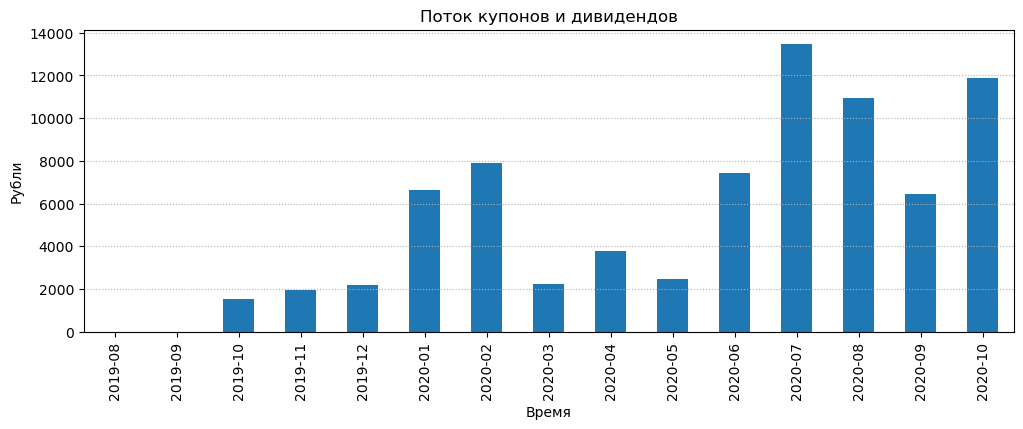

In [4]:
# Загрузка портфеля из отчетов
# Директория с отчетами в html формате
path = 'sber_reports/'
arr = [path + f for f in os.listdir(path) if f.endswith('.html')]
dfs = load_reports(arr)

# Рыночная стоимость активов
aa = dfs['Оценка активов']
per_aa = aa.date.dt.to_period('M')
g1 = aa.groupby(per_aa).sum()

# Зачисление денег на счета
bb = dfs['Движение денежных средств за период']
bb = bb[bb.operation == 'Зачисление д/с']
per_bb = bb.date.dt.to_period("M")
g2 = bb.groupby(per_bb).sum()

# Выводы  купонов на внешний счёт
cc = dfs['Выплаты дохода от эмитента на внешний счет']
per_cc = cc.date.dt.to_period("M")
g3 = cc.groupby(per_cc).sum()

# Учет дивидендов
# Сбер по непонятной мне причине не указывает дивиденды в отчётах =/
g3.loc['2020-05']['cash'] += 189.20 + 522.00
g3.loc['2020-06']['cash'] += 298.20 + 404.95 + 388.42 + 512.57 + 78.00 + \
    578.60 + 556.73 + 125.80 + 690.00
g3.loc['2020-07']['cash'] += 606.80 + 335.20 + 1218.00 + 407.00 + 895.50 + \
    418.00 + 13.00 + 579.15 + 683.00 + 524.80 + 798.50
g3.loc['2020-08']['cash'] += 195.61 + 366.00 + 1195.60 + 130.00
g3.loc['2020-09']['cash'] += 914.00 + 212.75 + 268.80
g3.loc['2020-10']['cash'] += 283.62 + 317.20 + 370.00 + 806.69 + 384.66 + \
    435.00 + 469.80 + 1629.00 + 537.50 + 988.50 + 319.78 + 184.76
#g3.loc['2020-11']['cash'] += 201.00 +209.18

# Учёт налогового вычета по ИИС тип А
g3.loc['2020-04']['cash'] += 52000

# Собираем всё в общую табличку
gg = g2[['inflow']].join(g3, how='left')
gg = g1[['all_cost']].join(gg, how='left')
gg.fillna(0, inplace=True)

# Вычитаем из внешнего денежного потока, то что мы вывели двиведендами и купонами
gg['inflow'] -= gg['cash']
gg['cum_inflow'] = gg['inflow'].cumsum()

yy = gg['cash'].copy()
yy.loc['2020-04'] -= 52000

# Рисуем график
plt.rcParams['figure.figsize'] = [12, 4]
ax1 = yy.plot.bar()
ax1.set_ylabel('Рубли')
ax1.set_xlabel('Время')
ax1.grid(axis='y', linestyle=':')
ax1.set_title(f'Поток купонов и дивидендов')

# Бенчмарк
В качестве бенчмарков выбираем 3 фонда:
* [SMBX](https://www.sberbank.ru/ru/person/investments/etf/offer?toolid=SBMX) - фонд Сбербанка Индекс МосБиржи полной доходности «брутто»
* [FXUS](https://finex-etf.ru/products/FXUS) - фонд FINEX акций США (индекс: [Solactive GBS United States Large & Mid Cap Index NTR](https://www.solactive.com/indices/gbs/?index=DE000SLA4YD9)). Индекс близок к [S&P500](https://www.spglobal.com/spdji/en/indices/equity/sp-500/#overview)
* [FXTB](https://finex-etf.ru/products/FXTB) - фонд FINEX краткосрочные гособлигации США (эквивалент валютного депозита)

Фонды пополняются независимо друг от друга в соответствии с графиком пополнения реального портфеля.

In [5]:
# Бенчмарки, с учетом суммарной комисии на покупку 0.06%
benchmarks = load_benchmarks(['SBMX', 'FXUS', 'FXTB'])
gg['sbmx_price']=benchmarks['SBMX']
gg['sbmx_stocks'] = (gg['inflow'] / gg['sbmx_price']) * (1-0.0006)
gg['sbmx'] = gg['sbmx_stocks'].cumsum() * gg['sbmx_price']

gg['fxus_price']=benchmarks['FXUS']
gg['fxus_stocks'] = (gg['inflow'] / gg['fxus_price']) * (1-0.0006)
gg['fxus'] = gg['fxus_stocks'].cumsum() * gg['fxus_price']

gg['fxtb_price']=benchmarks['FXTB']
gg['fxtb_stocks'] = (gg['inflow'] / gg['fxtb_price']) * (1-0.0006)
gg['fxtb'] = gg['fxtb_stocks'].cumsum() * gg['fxtb_price']

# Доходность
Расчёт дохожности осуществляется по приближенной формуле [Modified Dietz](https://en.wikipedia.org/wiki/Modified_Dietz_method) (на основе среднего капитала):

$$r=\frac{B-A-F}{A+\sum_{i=1}^n{W_i \cdot F_i}}$$

$A$ - первоначальные вложения;

$B$ - текущая стоимость портфеля;

$B$ - текущая стоимость портфеля;

$F=\sum_{i=1}^n{F_i}$ - суммарный внешний денежный поток;

$\sum_{i=1}^n{W_i \cdot F_i}$ - средневзвешенный денежный поток;

$W_i$ - вес $i$-го интервала из всех $n$ интервалов.

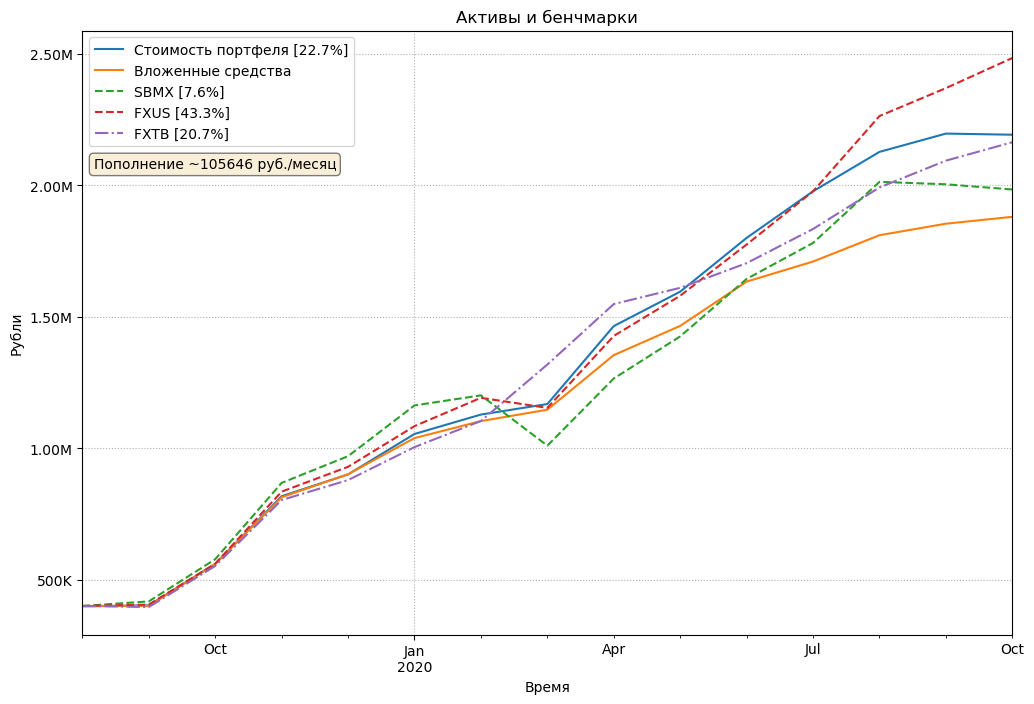

In [6]:
from operator import attrgetter
# Расчёт доходности по Modified Dietz
# За интервал берем месяц и высчитываем вес интервала
gg['period'] = (gg.index.to_series() - gg.index[0]).apply(attrgetter('n'))
gg['period'] = 1 - gg['period'] / gg.iloc[-1]['period']
month_num = (gg.index[-1]-gg.index[0]).n
gg.loc[gg.index[-1], 'period']= 1/month_num/2
gg['waf'] = gg['inflow'] * gg['period']

# Доходности
r = (gg.iloc[-1][['all_cost','sbmx', 'fxus', 'fxtb']] - gg.iloc[-1]['cum_inflow']) / gg['waf'].sum()
r = (r+1)**(12/month_num)-1

# Загрузка структуры портфеля
#pf_df = dfs['Портфель Ценных Бумаг']

# Рисуем график
plt.rcParams['figure.figsize'] = [12, 8]
ax1 = gg[['all_cost', 'cum_inflow', 'sbmx', 'fxus', 'fxtb']].plot(style=['-','-','--', '--', '-.'])
ax1.grid(axis='y', linestyle=':')
ax1.grid(axis='x', linestyle=':')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
mkfunc = lambda x, pos: '%1.2fM' % (x * 1e-6) if x >= 1e6 else '%1.0fK' % (x * 1e-3) if x >= 1e3 else '%1.1f' % x
mkformatter = matplotlib.ticker.FuncFormatter(mkfunc)
ax1.yaxis.set_major_formatter(mkformatter)
ax1.set_ylabel('Рубли')
ax1.set_xlabel('Время')
x = lambda s, e: f'{s} [{e*100:1.1f}%]'
ax1.legend([x('Стоимость портфеля',r['all_cost']), 'Вложенные средства', x('SBMX',r['sbmx']), x('FXUS',r['fxus']), x('FXTB',r['fxtb'])])
ax1.set_title(f'Активы и бенчмарки')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.012, 0.79, f"Пополнение ~{gg['inflow'][1:].mean():1.0f} руб./месяц", transform=ax1.transAxes, verticalalignment='top', bbox=props)
#plt.savefig('sber_portfolio.png')